# Using SD models to understand the differences between population measures at varying levels of geographic disagregation 
In this recipe, we will use data at a national level to infer parameters for a population aging model. We'll then try two different ways of using this trained model to understand variation between the behavior of each of the states. 


## About this technique
Firstly, we'll use the parameters fit at the national level to predict census data at the disaggregated level, and compare these predicted state-level outputs with the measured values. This gives us a sense for how different the populations of the states are from what we should expect given our understanding of the national picture.

Secondly, we'll fit parameters to a model at each of the state levels actual measured census data, and then compare the differences in fit parameters to each other and to the national expectation. This is a helpful analysis if the parameter itself (and its inter-state variance) is what we find interesting.

In [1]:
%pylab inline
import pandas as pd
import pysd
import scipy.optimize
import geopandas as gpd

Populating the interactive namespace from numpy and matplotlib


##Ingredients

### Population data by age cohort
We start with data from the decennial census years 2000 and 2010, for the male population by state and county. We have aggregated the data into ten-year age cohorts (with the last cohort representing everyone over 80 years old). The data collection task is described [here](data/Census/US Census Data Collection.ipynb). In this analysis we will only use data at the state and national levels.

In [2]:
data = pd.read_csv('../../data/Census/Males by decade and county.csv', header=[0,1], index_col=[0,1])
data.head()

2000                                                    \
               dec_1    dec_2   dec_3   dec_4    dec_5   dec_6   dec_7   
state county                                                             
1.0   1.0     3375.0   3630.0  2461.0  3407.0   3283.0  2319.0  1637.0   
      3.0     9323.0  10094.0  7600.0  9725.0  10379.0  8519.0  6675.0   
      5.0     2002.0   2198.0  2412.0  2465.0   2178.0  1699.0  1026.0   
      7.0     1546.0   1460.0  1680.0  1762.0   1624.0  1237.0   774.0   
      9.0     3741.0   3615.0  3393.0  3901.0   3773.0  3007.0  2227.0   

                                 2010                                     \
               dec_8   dec_9    dec_1    dec_2   dec_3    dec_4    dec_5   
state county                                                               
1.0   1.0      825.0   284.0   3867.0   4384.0  3082.0   3598.0   4148.0   
      3.0     4711.0  1822.0  11446.0  12006.0  9976.0  11042.0  12517.0   
      5.0      689.0   301.0   1673.0   1739.0  2260.0   2208.0   2233.0   
      7.0      475.0   187.0   1471.0   1577.0  1798.0   2016.0   1928.0   
      9.0     1269.0   550.0   3741.0   4252.0  3312.0   3719.0   4129.0   

                                                
                dec_6    dec_7   dec_8   dec_9  
state county                                    
1.0   1.0      3390.0   2293.0  1353.0   454.0  
      3.0     12368.0  10623.0  6307.0  2911.0  
      5.0      1910.0   1490.0   739.0   324.0  
      7.0      1581.0   1140.0   579.0   211.0  
      9.0      3782.0   3052.0  1723.0   652.0

###A model of an aging population

The model we'll use to represent the population is a simple aging chain, with individuals aggregated into stocks by decade, to match the agregation we used for the above data. Each cohort is promoted with a timescale of 10 years, and there is some net inmigration, outmigration, and death subsumed into the `loss` flow associated with each cohort. This loss is controled by some yearly fraction that it will be our task to understand. 

<img src="../../models/Aging_Chain/Aging_Chain.png" alt="Still Image of Vensim Aging Chain Model" style="width: 600px;"/>

In [3]:
model = pysd.read_vensim('../../models/Aging_Chain/Aging_Chain.mdl')

Our model is initialy parameterized with 10 individuals in each stock, no births, and a uniform loss rate of 5%. We'll use data to set the initial conditions, and infer the loss rates. Estimating births is difficult, and so for this analysis, we'll pay attention only to individuals who have been born before the year 2000.

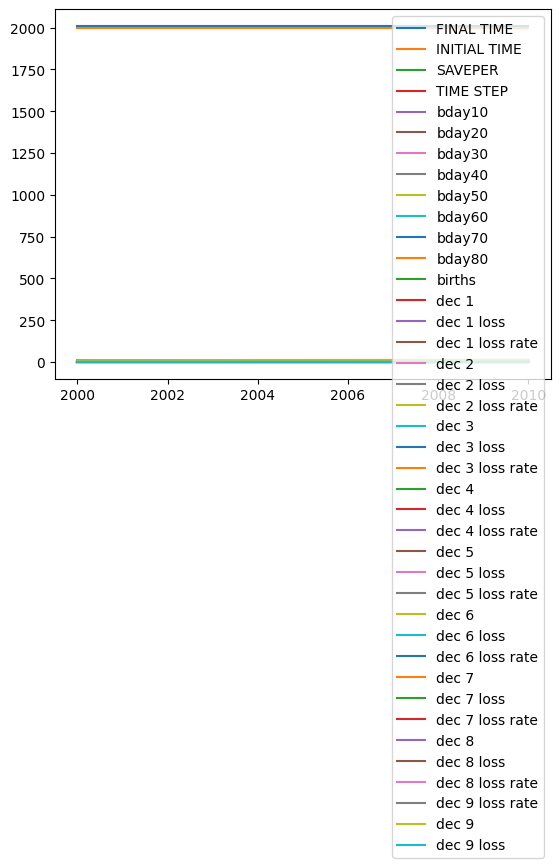

In [4]:
model.run().plot();

### Geography Information

This information comes to us as a shape file `.shp` with its associated `.dbf` and `.shx` conspirator files. Lets check the plotting functionality:

,OBJECTID,FIPS,FIPSNum,StateFIPS,StateName,CensusReg,CensusDiv,XCentroid,YCentroid,Notes,geometry
StateFIPSN,,,,,,,,,,,
2,1,02000,2000,02,Alaska,West,Pacific,-1.882092e+06,2.310348e+06,None,"MULTIPOLYGON (((-2247528.774 2237995.012, -224..."
53,9,53000,53000,53,Washington,West,Pacific,-1.837353e+06,1.340481e+06,None,"MULTIPOLYGON (((-2124362.243 1480441.851, -212..."


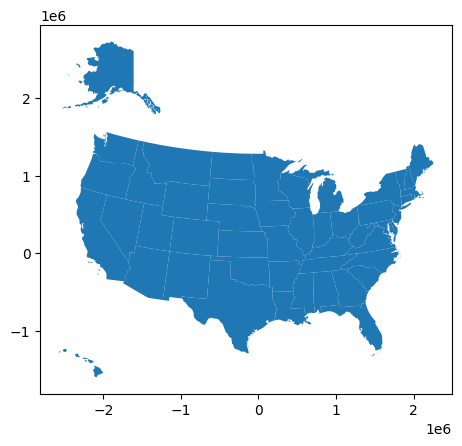

In [5]:
state_geo = gpd.read_file('../../data/Census/US_State.shp')
state_geo.set_index('StateFIPSN', inplace=True)
state_geo.plot();
state_geo.head(2)

## Recipe Part A: Predict state-level values from national model fit

### Step 1: Initialize the model using census data

We can aggregate the county level data to the national scale by summing across all geographies. This is relatively straightforward.

In [6]:
country = data.sum()
country

2000  dec_1    20332536.0
      dec_2    20909490.0
      dec_3    19485544.0
      dec_4    21638975.0
      dec_5    21016627.0
      dec_6    15115009.0
      dec_7     9536197.0
      dec_8     6946906.0
      dec_9     3060483.0
2010  dec_1    20703935.0
      dec_2    21878666.0
      dec_3    21645336.0
      dec_4    20033352.0
      dec_5    21597437.0
      dec_6    20451686.0
      dec_7    13926846.0
      dec_8     7424945.0
      dec_9     4083435.0
dtype: float64

If we run the model using national data from the year 2000 as starting conditions, we can see how the cohorts develop, given our arbitrary loss rate values:

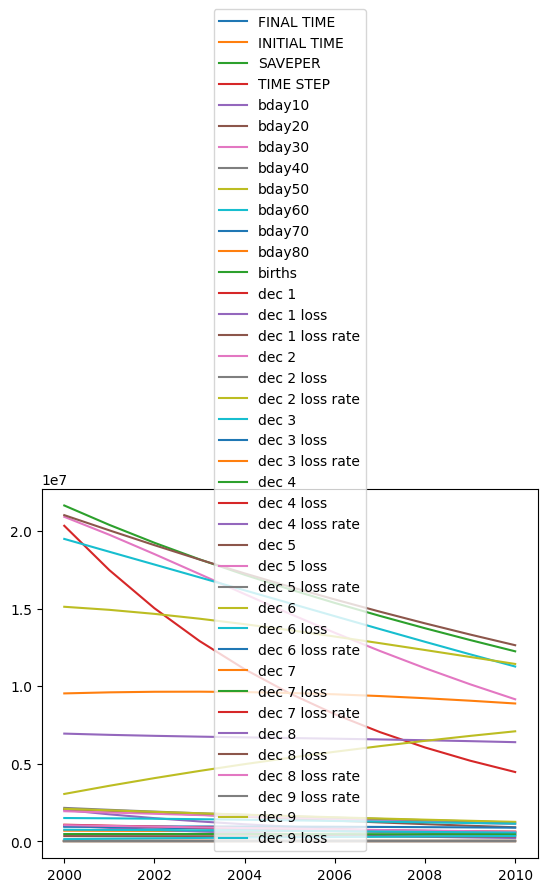

In [7]:
model.run(return_timestamps=range(2000,2011), 
          initial_condition=(2000, country['2000'])).plot();

### Step 2: Fit the national level model to the remaining data
We've used half of our data (from the year 2000 census) to initialize our model. Now we'll use an optimization routine to choose the loss rate parameters that best predict the census 2010 data. We'll use the same basic operations described in the previous recipe: [Fitting with Optimization](2_1_Fitting_with_Optimization.ipynb).

To make this simple, we'll write a function that takes a list of potential model parameters, and returns the model's prediction in the year 2010


In [8]:
def exec_model(paramlist):
    params = dict(zip(['dec_%i_loss_rate'%i for i in range(1,10)], paramlist)) 
    output = model.run(initial_condition=(2000,country['2000']),
                       params=params, return_timestamps=2010)
    return output

Now we'll define an error function that calls this executor and calculates a sum of squared errors value. Remember that because we don't have birth information, we'll only calculate error based upon age cohorts 2 through 9.

In [9]:
def error(paramlist):
    output = exec_model(paramlist)
    errors = output - country['2010']
    #don't tally errors in the first cohort, as we don't have info about births
    return sum(errors.values[0,1:]**2)

Now we can use the minimize function from scipy to find a vector of parameters which brings the 2010 predictions into alignment with the data.

In [10]:
res = scipy.optimize.minimize(error, x0=[.05]*9,
                              method='L-BFGS-B')
country_level_fit_params = dict(zip(['dec_%i_loss_rate'%i for i in range(1,10)], res['x']))
country_level_fit_params

{'dec_1_loss_rate': 0.05,
 'dec_2_loss_rate': 0.05,
 'dec_3_loss_rate': 0.05,
 'dec_4_loss_rate': 0.05,
 'dec_5_loss_rate': 0.05,
 'dec_6_loss_rate': 0.05,
 'dec_7_loss_rate': 0.05,
 'dec_8_loss_rate': 0.05,
 'dec_9_loss_rate': 0.05}

If we run the national model forwards with these parameters, we see generally good behavior, except for the 0-9yr demographic bracket, from whom we expect less self-control. (And because we don't have births data.)

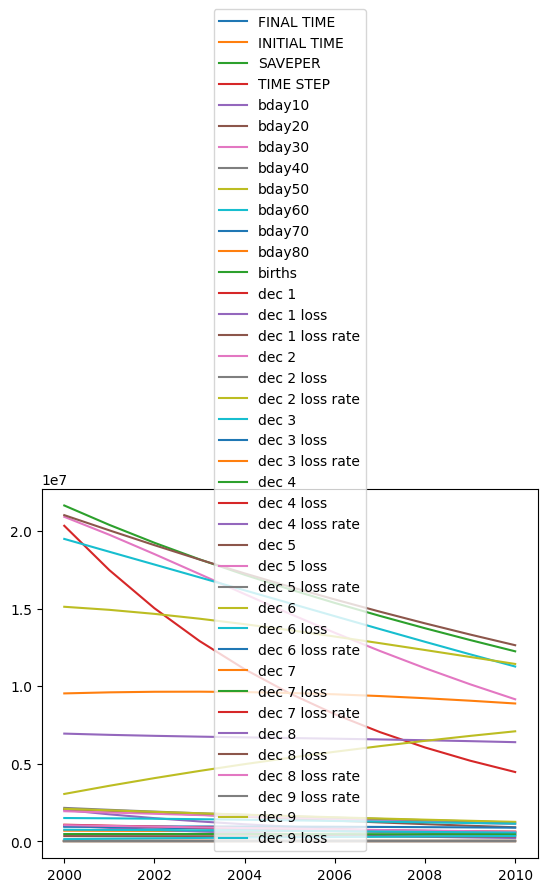

In [11]:
model.run(params=country_level_fit_params,
          return_timestamps=range(2000,2011), 
          initial_condition=(2000, country['2000'])).plot();

###Step 3: Make state-level predictions

If we want to look at the variances between the states and the national level, we can try making state-level predictions using state-specific initial conditions, but parameters fit at the national level.

In [12]:
states = data.groupby(level=0).sum()
states.head()

2000                                                         \
           dec_1      dec_2      dec_3      dec_4      dec_5      dec_6   
state                                                                     
1.0     312841.0   329043.0   301076.0   315262.0   321447.0   246427.0   
2.0      50687.0    53992.0    42537.0    51442.0    56047.0    35804.0   
4.0     395110.0   384672.0   386486.0   391330.0   352471.0   257798.0   
5.0     188589.0   201405.0   180801.0   187516.0   186931.0   149142.0   
6.0    2669364.0  2588761.0  2556975.0  2812648.0  2495158.0  1692007.0   

                                           2010                        \
           dec_7     dec_8     dec_9      dec_1      dec_2      dec_3   
state                                                                   
1.0     165327.0  109918.0   45131.0   312605.0   338568.0   321236.0   
2.0      14974.0    7628.0    2325.0    53034.0    52278.0    58166.0   
4.0     187193.0  144837.0   61148.0   463808.0   466275.0   455170.0   
5.0     104621.0   72629.0   33050.0   201821.0   205074.0   196956.0   
6.0    1002881.0  725610.0  331342.0  2573619.0  2780997.0  2849483.0   

                                                                       
           dec_4      dec_5      dec_6      dec_7     dec_8     dec_9  
state                                                                  
1.0     297502.0   321810.0   318358.0   229496.0  124070.0   56543.0  
2.0      47753.0    51856.0    54170.0    29869.0   10392.0    4151.0  
4.0     422447.0   418398.0   381076.0   300553.0  178849.0   89247.0  
5.0     183761.0   192596.0   188081.0   143285.0   81138.0   38925.0  
6.0    2595717.0  2655307.0  2336519.0  1489395.0  780576.0  456217.0

We can now generate a prediction by setting the model's intitial conditions with state level data, and parameters fit in the national case. I've created a `model_runner` helper function to make the code easier to read, but this could be conducted in a single line if we so chose.

In [13]:
def model_runner(row):
    result = model.run(params=country_level_fit_params, 
                       initial_condition=(2000, row['2000']), 
                       return_timestamps=2010,
                       return_columns=[
                           "dec_1", "dec_2", "dec_3", 
                           "dec_4", "dec_5", "dec_6",
                           "dec_7", "dec_8", "dec_9"
                       ])
    return result.loc[2010]
    
state_predictions = states.apply(model_runner, axis=1)
state_predictions.head()

,dec_1,dec_2,dec_3,dec_4,dec_5,dec_6,dec_7,dec_8,dec_9
state,,,,,,,,,
1.0,68817.239206,1.425135e+05,1.752830e+05,1.856499e+05,1.905074e+05,1.766502e+05,1.430809e+05,104576.864395,112780.892489
2.0,11149.879343,2.323983e+04,2.717858e+04,2.883606e+04,3.114106e+04,2.841718e+04,2.006445e+04,11731.576605,9263.036022
4.0,86914.373061,1.731934e+05,2.158222e+05,2.308789e+05,2.268514e+05,1.985338e+05,1.576861e+05,120469.144700,140567.692416
5.0,41484.889527,8.658169e+04,1.061958e+05,1.115457e+05,1.128048e+05,1.048007e+05,8.660780e+04,65340.896065,74727.981971
6.0,587193.689179,1.167877e+06,1.443928e+06,1.583683e+06,1.589019e+06,1.372822e+06,1.015240e+06,699665.480214,759574.642778


### Step 4: Compare model predictions with measured data
Comparing the state level predictions with the actual data, we can see where our model most under or overpredicts population for each region/cohort combination.

In [14]:
diff = state_predictions-states['2010']
diff.head()

,dec_1,dec_2,dec_3,dec_4,dec_5,dec_6,dec_7,dec_8,dec_9
state,,,,,,,,,
1.0,-2.437878e+05,-1.960545e+05,-1.459530e+05,-1.118521e+05,-1.313026e+05,-141707.812835,-86415.080653,-19493.135605,56237.892489
2.0,-4.188412e+04,-2.903817e+04,-3.098742e+04,-1.891694e+04,-2.071494e+04,-25752.819389,-9804.550877,1339.576605,5112.036022
4.0,-3.768936e+05,-2.930816e+05,-2.393478e+05,-1.915681e+05,-1.915466e+05,-182542.183715,-142866.899500,-58379.855300,51320.692416
5.0,-1.603361e+05,-1.184923e+05,-9.076017e+04,-7.221535e+04,-7.979121e+04,-83280.336688,-56677.198680,-15797.103935,35802.981971
6.0,-1.986425e+06,-1.613120e+06,-1.405555e+06,-1.012034e+06,-1.066288e+06,-963697.077944,-474154.512342,-80910.519786,303357.642778


This is a little easier to understand if we weight it by the actual measured population:

In [15]:
diff_percent = (state_predictions-states['2010'])/states['2010']
diff_percent.head()

,dec_1,dec_2,dec_3,dec_4,dec_5,dec_6,dec_7,dec_8,dec_9
state,,,,,,,,,
1.0,-0.779859,-0.579070,-0.454348,-0.375971,-0.408013,-0.445121,-0.376543,-0.157114,0.994604
2.0,-0.789760,-0.555457,-0.532741,-0.396141,-0.399470,-0.475407,-0.328252,0.128905,1.231519
4.0,-0.812607,-0.628559,-0.525843,-0.453473,-0.457810,-0.479018,-0.475347,-0.326420,0.575041
5.0,-0.794447,-0.577803,-0.460814,-0.392985,-0.414293,-0.442790,-0.395556,-0.194694,0.919794
6.0,-0.771841,-0.580051,-0.493267,-0.389886,-0.401568,-0.412450,-0.318354,-0.103655,0.664942


###Step 5: Merge with geo data to plot

I'm using geopandas to manage the shapefiles, and it has its own plotting functionality. Unfortunately, it is not a particularly well defined functionality.

,OBJECTID,FIPS,FIPSNum,StateFIPS,StateName,CensusReg,CensusDiv,XCentroid,YCentroid,Notes,geometry,dec_1,dec_2,dec_3,dec_4,dec_5,dec_6,dec_7,dec_8,dec_9
StateFIPSN,,,,,,,,,,,,,,,,,,,,
2,1,02000,2000,02,Alaska,West,Pacific,-1.882092e+06,2.310348e+06,None,"MULTIPOLYGON (((-2247528.774 2237995.012, -224...",-0.789760,-0.555457,-0.532741,-0.396141,-0.399470,-0.475407,-0.328252,0.128905,1.231519
53,9,53000,53000,53,Washington,West,Pacific,-1.837353e+06,1.340481e+06,None,"MULTIPOLYGON (((-2124362.243 1480441.851, -212...",-0.792005,-0.585096,-0.510514,-0.430876,-0.426070,-0.459076,-0.393843,-0.135940,0.674966
23,10,23000,23000,23,Maine,Northeast,New England,2.068850e+06,1.172787e+06,None,"MULTIPOLYGON (((1951177.135 1127914.539, 19511...",-0.765509,-0.556475,-0.409031,-0.338041,-0.430710,-0.473652,-0.409398,-0.164981,0.726818
27,11,27000,27000,27,Minnesota,Midwest,West North Central,1.310476e+05,9.821300e+05,None,"POLYGON ((-91052.168 1282100.079, -30035.391 1...",-0.786822,-0.557537,-0.463915,-0.369641,-0.403840,-0.452106,-0.335580,-0.123440,0.645598
26,18,26000,26000,26,Michigan,Midwest,East North Central,8.425679e+05,8.094373e+05,None,"MULTIPOLYGON (((764918.731 786184.882, 772386....",-0.746814,-0.547370,-0.378482,-0.282202,-0.364176,-0.423316,-0.329958,-0.074694,0.747247


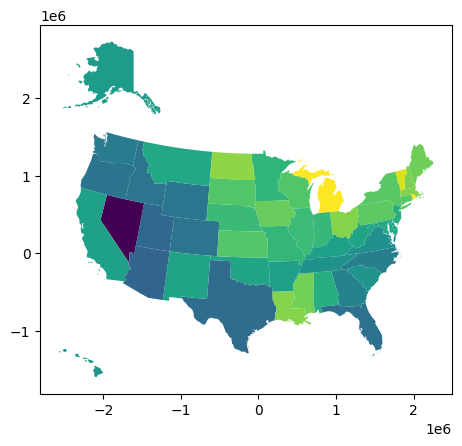

In [16]:
geo_diff = state_geo.join(diff_percent)
geo_diff.plot(column='dec_4')
geo_diff.head()

## Recipe Part B: fit state-by-state models

Now lets try optimizing the model's parameters specifically to each state, and comparing with the national picture. 

### Step 1: Write the optimization functions to account for the state
We'll start as before with functions that run the model and compute the error (this time with a parameter for the information about the state in question) and add a function to optimize and return the best fit parameters for each state.

In [17]:
def exec_model(paramlist, state):
    params = dict(zip(['dec_%i_loss_rate'%i for i in range(1,10)], paramlist)) 
    output = model.run(initial_condition=(2000,state['2000']),
                       params=params, return_timestamps=2010).loc[2010]
    return output

def error(paramlist, state):
    output = exec_model(paramlist, state)
    errors = output - state['2010']
    #don't tally errors in the first cohort, as we don't have info about births
    sse = sum(errors.values[1:]**2)
    return sse

###Step 2: Apply optimization to each state
We can wrap the optimizer in a function that takes census information about each state and returns an optimized set of parameters for that state. If we apply it to the states dataframe, we can get out a similar dataframe that includes optimized parameters.

In [18]:
%%capture 
def optimize_params(row):
    res = scipy.optimize.minimize(lambda x: error(x, row),
                                  x0=[.05]*9,
                                  method='L-BFGS-B');
    return pd.Series(index=['dec_%i_loss_rate'%i for i in range(1,10)], data=res['x'])
    
state_fit_params = states.apply(optimize_params, axis=1)
state_fit_params.head()

### Step 3: Merge with geographic data
As we're looking at model parameters which themselves are multiplied by populations to generate actual flows of people, we can look at the difference between parameters directly without needing to normalize.

,OBJECTID,FIPS,FIPSNum,StateFIPS,StateName,CensusReg,CensusDiv,XCentroid,YCentroid,Notes,geometry,dec_1_loss_rate,dec_2_loss_rate,dec_3_loss_rate,dec_4_loss_rate,dec_5_loss_rate,dec_6_loss_rate,dec_7_loss_rate,dec_8_loss_rate,dec_9_loss_rate
StateFIPSN,,,,,,,,,,,,,,,,,,,,
2,1,02000,2000,02,Alaska,West,Pacific,-1.882092e+06,2.310348e+06,None,"MULTIPOLYGON (((-2247528.774 2237995.012, -224...",0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
53,9,53000,53000,53,Washington,West,Pacific,-1.837353e+06,1.340481e+06,None,"MULTIPOLYGON (((-2124362.243 1480441.851, -212...",0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
23,10,23000,23000,23,Maine,Northeast,New England,2.068850e+06,1.172787e+06,None,"MULTIPOLYGON (((1951177.135 1127914.539, 19511...",0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


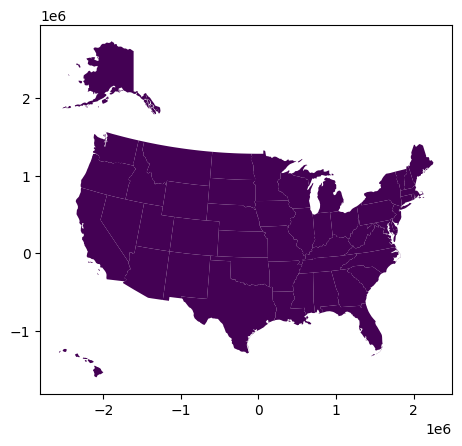

In [19]:
geo_diff = state_geo.join(state_fit_params)
geo_diff.plot(column='dec_4_loss_rate')
geo_diff.head(3)